<a href="https://colab.research.google.com/github/bullbeary-bots/Colabs/blob/main/pca_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [6]:
!pip install ta

In [7]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data management
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised machine learning
from sklearn.decomposition import PCA

# Supervised machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# Visualization
import matplotlib.pyplot as plt

### Initial data extraction

In [8]:
# Data extraction
start_date = '2017-01-01'
end_date = '2023-01-01'
symbol = '^VIX'

df = yf.download(symbol, start=start_date, end=end_date,
                 multi_level_index=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2017-01-03,12.85,14.07,12.85,14.07,0
2017-01-04,11.85,12.80,11.63,12.78,0
2017-01-05,11.67,12.09,11.40,11.96,0
2017-01-06,11.32,11.74,10.98,11.70,0
2017-01-09,11.56,12.08,11.46,11.71,0


In [9]:
# Add technical analysis
df = add_all_ta_features(df, open="Open", high="High", low="Low",
                         close="Close", volume="Volume", fillna=True)
df.head()

,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,12.85,14.07,12.85,14.07,0,-0.0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.850000,0.000000,0.000000,0.000000
2017-01-04,11.85,12.80,11.63,12.78,0,-0.0,0,0.0,-0.0,0.0,...,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.342122,-7.782101,-8.101594,-7.782101
2017-01-05,11.67,12.09,11.40,11.96,0,-0.0,0,0.0,-0.0,0.0,...,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,12.053566,-1.518990,-1.530645,-9.182881
2017-01-06,11.32,11.74,10.98,11.70,0,-0.0,0,0.0,-0.0,0.0,...,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,11.812227,-2.999146,-3.045041,-11.906620
2017-01-09,11.56,12.08,11.46,11.71,0,-0.0,0,0.0,-0.0,0.0,...,-2.289756,-0.985604,-1.304152,0.0,0.0,0.0,11.703542,2.120148,2.097985,-10.038910


### Data Preprocessing - Stationarity

In [12]:
# Identify non-stationary columns or features
non_stationaries = []

for col in df.columns:
  try:
    df_test = adfuller(df[col].values)
    p_value = df_test[1]
    t_test = df_test[0] < df_test[4]["1%"]

    if p_value > 0.05 or not t_test:
      non_stationaries.append(col)
  except:
    pass

print(f"Non-stationary columns: {len(non_stationaries)}")
print(non_stationaries)

Non-stationary columns: 10
['volatility_bbl', 'volatility_kcl', 'volatility_dcl', 'volatility_dcm', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_slow', 'trend_ichimoku_b', 'trend_visual_ichimoku_b', 'momentum_kama']


In [14]:
# Convert non-stationary to stationary
df_stationary = df.copy()

df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [15]:
# Find NaN rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [16]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,11.85,12.80,11.63,12.78,0,-0.0,0,0.0,-0.0,0.0,...,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,-0.039524,-7.782101,-8.101594,-7.782101
2017-01-05,11.67,12.09,11.40,11.96,0,-0.0,0,0.0,-0.0,0.0,...,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,-0.023380,-1.518990,-1.530645,-9.182881
2017-01-06,11.32,11.74,10.98,11.70,0,-0.0,0,0.0,-0.0,0.0,...,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,-0.020022,-2.999146,-3.045041,-11.906620
2017-01-09,11.56,12.08,11.46,11.71,0,-0.0,0,0.0,-0.0,0.0,...,-2.289756,-0.985604,-1.304152,0.0,0.0,0.0,-0.009201,2.120148,2.097985,-10.038910
2017-01-10,11.49,11.79,11.31,11.59,0,-0.0,0,0.0,-0.0,0.0,...,-2.607109,-1.309905,-1.297204,0.0,0.0,0.0,-0.006446,-0.605542,-0.607383,-10.583662


### Data Preprocessing - Scaling and Target Setting

In [17]:
# Set target (for supervised ML later on)
df_stationary['Target'] = -1
df_stationary.loc[df_stationary.Close.shift(-1) > df_stationary.Close, 'Target'] = 1

In [18]:
df_stationary.dropna(inplace=True)

In [19]:
# Split target from feature set
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [20]:
# Feature scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.3,
                                                    random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

In [28]:
# PCA
n_components = 8
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)

X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [29]:
# Calculate the variance explained by principle components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\n Total variance explained: ",
      round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Variance of each component:  [0.33922501 0.2292418  0.08920509 0.04776829 0.03149767 0.02971844
 0.02291073 0.01926458]

 Total variance explained:  80.88


In [30]:
# Create columns
pca_cols = []

for i in range(n_components):
  pca_cols.append(f"PC_{i}")

pca_cols

print(pca_cols)

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7']


In [31]:
# Create and view dataframe
df_pca = pd.DataFrame(
    data=X_train_pca,
    columns=pca_cols
)

df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,2.170641,0.867689,-1.941064,-0.696735,-1.230239,-1.006602,-0.703839,0.820486
1,-4.444436,2.326582,2.995226,-0.642073,0.138726,1.925040,1.539870,-0.385915
2,2.474252,-1.151516,0.780497,-0.980364,-0.405590,0.229404,-0.109356,-0.355518
3,-6.444544,0.326728,1.304191,0.392518,1.512749,0.233687,0.728887,0.200883
4,-1.145320,-5.910661,0.203038,-1.613858,-0.971595,-0.725417,0.176309,-0.343403


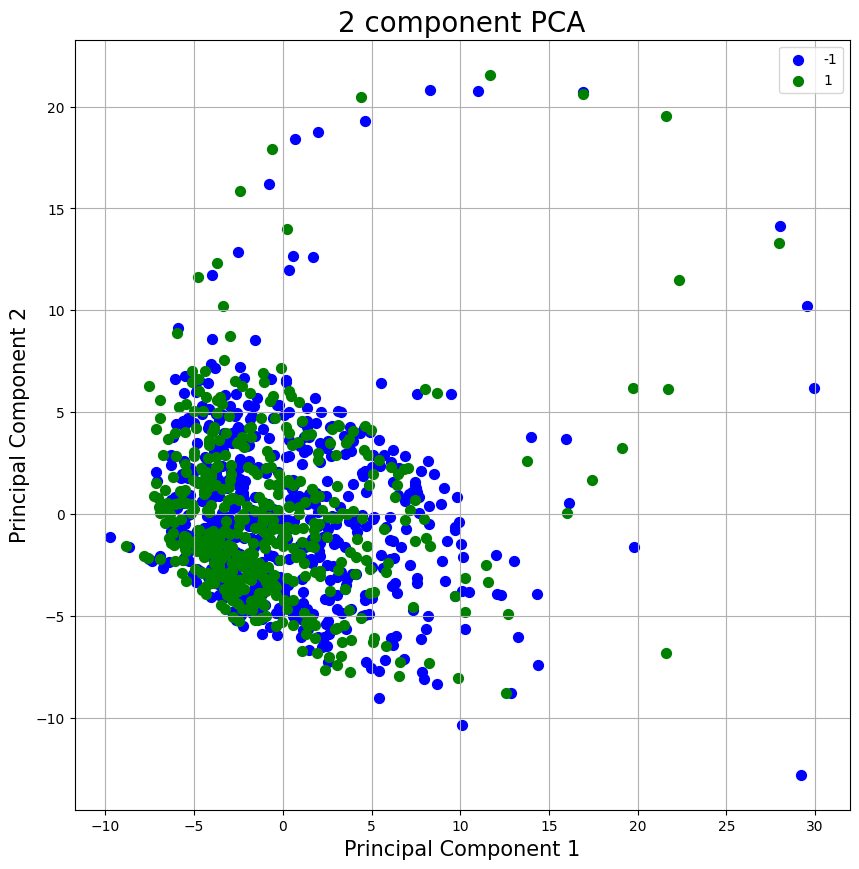

In [39]:
# Visualize principal components with scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
  indices_to_keep = y_train == target
  indices_to_keep = list(indices_to_keep)
  ax.scatter(df_pca.loc[indices_to_keep, 'PC_0'],
             df_pca.loc[indices_to_keep, 'PC_1'],
             c=color,
             s=50)
ax.legend(targets)
ax.grid()

### Supervised ML - Random Forest Classification

In [44]:
classifier = RandomForestClassifier(n_estimators=12,
                                    max_depth=2,
                                    random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

Accuracy: 0.5496688741721855
Precision: 0.5555555555555556


In [45]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.55565841, 0.44434159],
       [0.59030004, 0.40969996],
       [0.55256767, 0.44743233],
       [0.52899091, 0.47100909],
       [0.60873359, 0.39126641],
       [0.52842237, 0.47157763],
       [0.50956738, 0.49043262],
       [0.51266554, 0.48733446],
       [0.51358184, 0.48641816],
       [0.59068411, 0.40931589],
       [0.54450174, 0.45549826],
       [0.59418391, 0.40581609],
       [0.65212424, 0.34787576],
       [0.6700245 , 0.3299755 ],
       [0.56711538, 0.43288462],
       [0.59388719, 0.40611281],
       [0.55565841, 0.44434159],
       [0.69374245, 0.30625755],
       [0.55577662, 0.44422338],
       [0.54791267, 0.45208733],
       [0.65076305, 0.34923695],
       [0.54418662, 0.45581338],
       [0.58301266, 0.41698734],
       [0.52405908, 0.47594092],
       [0.54020473, 0.45979527],
       [0.52899091, 0.47100909],
       [0.51266554, 0.48733446],
       [0.58230982, 0.41769018],
       [0.55171246, 0.44828754],
       [0.57042466, 0.42957534],
       [0.

In [46]:
# Test for overfitting
train_scores, test_scores = [], []
values = [i for i in range(1, 200)]

for i in values:
  classifier = RandomForestClassifier(n_estimators=i,
                                    max_depth=2,
                                    random_state=0)
  classifier.fit(X_train, y_train)

  # Train data
  y_pred_train = classifier.predict(X_train)
  accuracy_train = accuracy_score(y_train, y_pred_train)
  train_scores.append(accuracy_train)

  # Test data
  y_pred_test = classifier.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred_test)
  test_scores.append(accuracy_test)

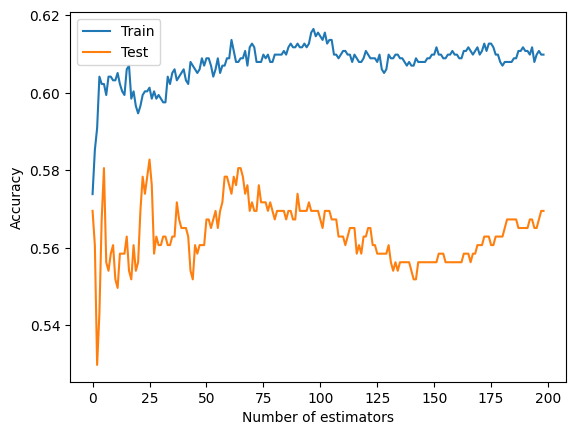

In [47]:
# Plot results
plt.plot(train_scores)
plt.plot(test_scores)
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])
plt.show()